# Fraud detection

## Finding people of interest and indicative language, Part 4

### The Enron Corporation

![logo4](images/Enron%20logo4.png)


As with any notebook we must begin by importing the libraries we'll need.

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import calinski_harabaz_score, adjusted_rand_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score #, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We can use pandas to open the dataframe we created in part 1 that contained the unprocessed emails since we saved it as a .csv file.

In [2]:
df = pd.read_csv("df.csv")

In [3]:
df.head()

,date_time,to_field,from_field,subject,body
0,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",jarnold@enron.com,msagel@home.com,Status,John:\n?\nI'm not really sure what happened be...
1,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",john.arnold@enron.com,slafontaine@globalp.com,re:summer inverses,i suck-hope youve made more money in natgas la...
2,"Tue, 15 May 2001 09:43:00 -0700 (PDT)","icehelpdesk@intcx.com, internalmarketing@intcx...",iceoperations@intcx.com,The WTI Bullet swap contracts,"Hi,\n\n\n Following the e-mail you have rece..."
3,"Mon, 27 Nov 2000 01:49:00 -0800 (PST)","anthony.gilmore@enron.com, colleen.koenig@enro...",jeff.youngflesh@enron.com,Invitation: EBS/GSS Meeting w/Bristol Babcock ...,Conference Room TBD. \n\nThis meeting will be...
4,"Tue, 12 Dec 2000 09:33:00 -0800 (PST)",mike.grigsby@enron.com,caroline.abramo@enron.com,Harvard Mgmt,Mike- I have their trader coming into the offi...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495554 entries, 0 to 495553
Data columns (total 5 columns):
date_time     495554 non-null object
to_field      495554 non-null object
from_field    495554 non-null object
subject       476732 non-null object
body          495554 non-null object
dtypes: object(5)
memory usage: 18.9+ MB


We'll start to make use of machine learning in this notebook, mostly with SciKitLearn.  The first step is to feature engineer, i.e.  vectorize the text.    Sklearn has a built in TF-IDF vectorizer that makes this easy.  

TF-IDF is term frequency–inverse document frequency and is a  statistic that reflects how important a word is to a corpus, in our case the full email dataset.  We're using it as a weighting factor to help adjust for the fact that some words appear more frequently in a general sense (not just in our corpus).

In [5]:
#creating the vector object
vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.5, min_df = 2)

#fitting the vectorizer to the corpus
X = vectorizer.fit_transform(df.body)

In [6]:
#the vectorizer outputs a sparse matrix of words, let's see how big it is
X.shape

(495554, 384952)

That is a very large matrix, too large to convert to a dense matrix.  So we'll take a slice of the first 10,000 rows and columsn to review.  Then we will make use of principal component analysis so we can plot the vectors. 

<function matplotlib.pyplot.show(*args, **kw)>

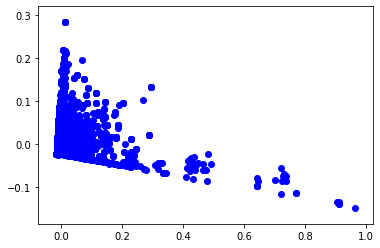

In [7]:
#slicing the first 10,000 rows and columns
X_slice = X[:10000,:10000]

#making our matrix 2D
X_dense = X_slice.todense()

#crating coordinates for a plot using PCA
coords = PCA(n_components =2).fit_transform(X_dense)
x= coords[:,0]
y=coords[:,1]

#creating the plot 
plt.scatter(x,y, c='b')
plt.show

We can force these back into a dataframe and look at the top words as well as their TF_IDF score.

In [8]:
#number of top words to grab
n = 25
#retrieving words from TF-IDF vector
feats = vectorizer.get_feature_names()
#Remove single-dimensional entries from X to get the rows to use
row = np.squeeze(X[1].toarray())
#sorting the rows
top_ids = np.argsort(row)[::-1][:n]
#creating a tuple of top features and their scores
top_feats = [(feats[i],row[i])for i in top_ids]
#saving the features to a df
top_df = pd.DataFrame(top_feats, columns=['features','score'])

In [9]:
top_df

,features,score
0,shud,0.517757
1,invert,0.297980
2,youve,0.290464
3,feb,0.271427
4,cuz,0.228539
5,natgas,0.216520
6,suck,0.212394
7,bearish,0.204020
8,mkt,0.195774
9,switching,0.182616


This is a great weighting scheme to use with a wordcloud which we can do easily with the new dataframe.

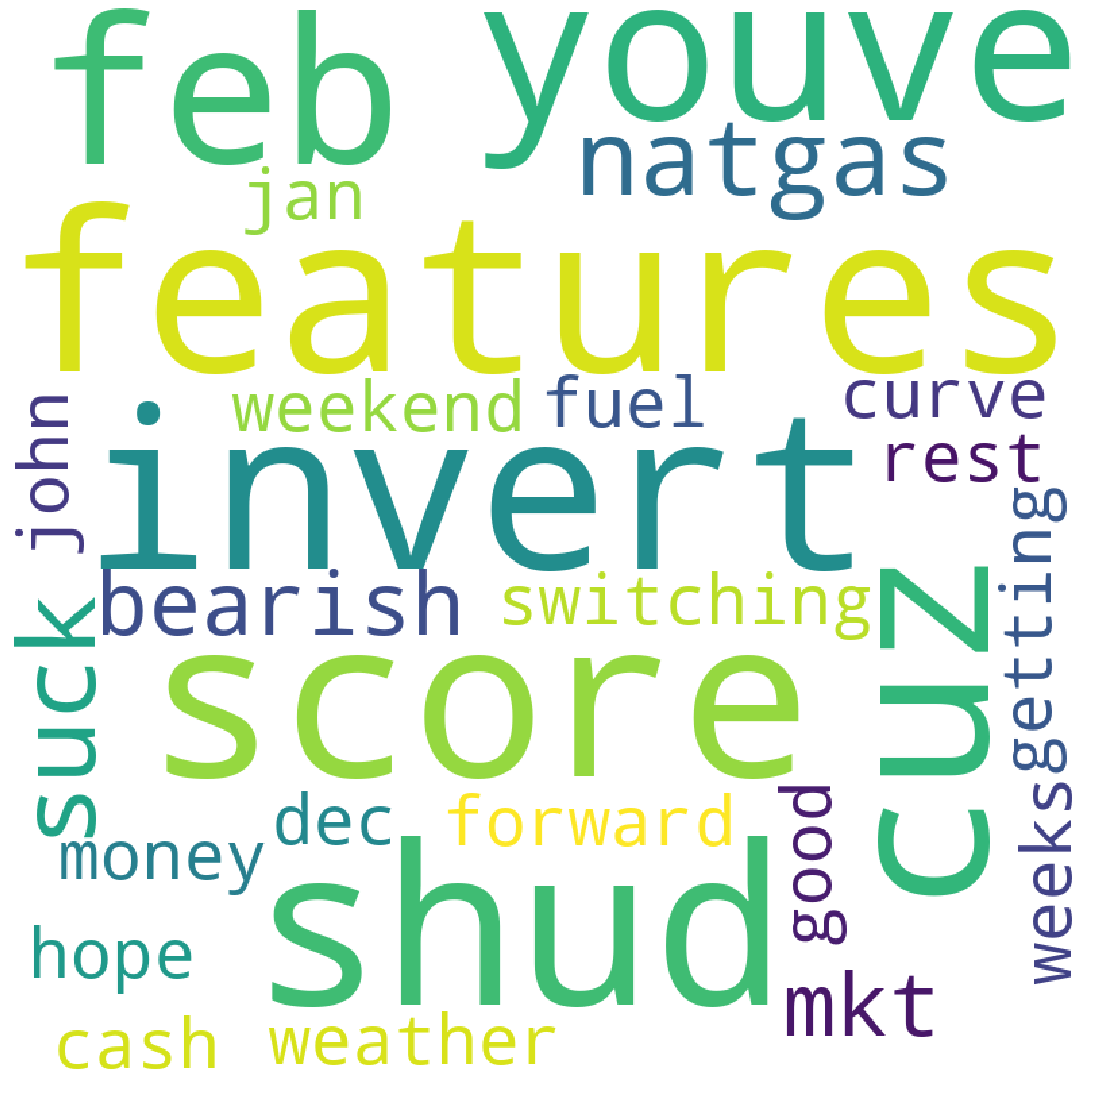

In [10]:
#creating WordCloud object

top_words = str(top_df)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = 'english', 
                min_font_size = 10).generate(top_words)

# plot the WordCloud image                        
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Now that we have everything all settled, we can use K-Means Clustering to separate our data.  The goal here is hopefully to sort everything into sections, people and important words.  We'll use these later on as labels in our supervised learning task.  

K-means is a clustering algorithm that aims to partition the data into _k_ clusters.  These clusters are organized by separating each observation and linking it to the cluster with the nearest mean.  

We'll actually use the mini-batch Kmeans algorithm from sklearn.  This way we won't read the whole dataset into memory at the same time.  We'll use a batch size of 500 and run 100 iterations.

In [11]:

#initializing with 2 clusters and a batch size
clusters = 2
batch = 500

#timing our model
start = datetime.now()
#starting with 100 iterations using minibatch 
kmeans = MiniBatchKMeans(n_clusters = clusters, max_iter=100, batch_size=batch)
labels = kmeans.fit_predict(X)

end= datetime.now()
print(f"Elapsed time",(end-start))

Elapsed time 0:00:02.284900


We can use the same plot as before, using a different color for each cluster

<function matplotlib.pyplot.show(*args, **kw)>

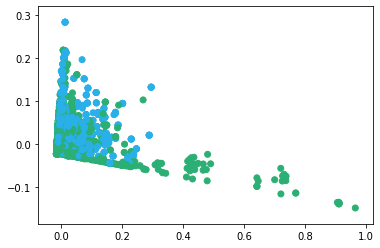

In [12]:
#reusing our previous variables but adding the labels for color (min number of colors is n_clusters)
label = labels[:10000]

label_colors = ["#2AB0E9","#2BAF74","#D7665E","#CCCCCC"]

colors = [label_colors[i] for i in label]

#crating coordinates for a plot using PCA
coords = PCA(n_components =2).fit_transform(X_dense)
x= coords[:,0]
y=coords[:,1]


#creating the plot 
plt.scatter(x,y, c=colors)
plt.show

There's a little more overlap than we'd like to see.  We can improve this by increasing the size of our slice to 40,000 and re-running the last few cells.  


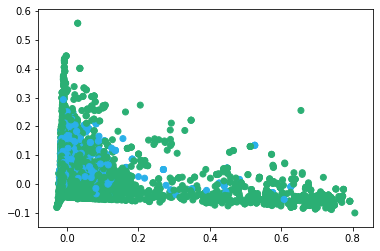

In [13]:
#slicing the first 40,000 rows and columns
X_slice2 = X[:40000,:40000]

#making our matrix 2D
X_dense2 = X_slice2.todense()

#reusing our previous variables but adding data
label2 = labels[:40000]

colors2 = [label_colors[i] for i in label2]

#crating coordinates for a plot using PCA
coords2 = PCA(n_components =2).fit_transform(X_dense2)
x2= coords2[:,0]
y2=coords2[:,1]


#creating the plot 
plt.scatter(x2,y2, c=colors2)
plt.show()


We can look at the top features, and add them to a dataframe to look at. 

In [14]:

clusters = np.unique(label2)


In [15]:
#looking at the top 25 words/scores
row = np.squeeze(X[1].toarray())
topn_ids = np.argsort(row)[::1][:n]
top_feats = [(feats[i], row[i]) for i in topn_ids]
top_df2 = pd.DataFrame(top_feats, columns= ["features","score"])
top_df2.head(25)

,features,score
0,00,0.0
1,modifica,0.0
2,modifiactions,0.0
3,modifi,0.0
4,modif,0.0
5,modied,0.0
6,modicum,0.0
7,modi,0.0
8,modfied,0.0
9,modfication,0.0


We will re-do our dataframe so it's sorted in descending order, then look at the top features.

In [16]:
#adding the cluster ids and looking at the whole dataset
ids = X[clusters].toarray()
ids[ids<0.1]=0
avg_score = np.mean(ids, axis=0)


top_ids = np.argsort(-avg_score)[::1][:n]
all_feats = [(feats[i], avg_score[i]) for i in top_ids]

In [17]:
all_feats

[('shud', 0.2588785642844799),
 ('energy2000', 0.15584170172588102),
 ('invert', 0.14899013326710636),
 ('youve', 0.145232101755325),
 ('feb', 0.1357133819185621),
 ('0245', 0.1289370525277608),
 ('psytech', 0.12491457491067835),
 ('sagel', 0.11978753655912114),
 ('cuz', 0.11426927325814167),
 ('weekend', 0.11132036125251865),
 ('natgas', 0.10825991361842342),
 ('suck', 0.10619677109765904),
 ('1112', 0.10591293447465976),
 ('interested', 0.10235609093735197),
 ('bearish', 0.10200987079367245),
 ('screw', 0.10144217661663237),
 ('308', 0.09917970437537686),
 ('mkt', 0.09788682466007893),
 ('blown', 0.09577742859897526),
 ('switching', 0.09130823229299682),
 ('analytics', 0.09127469987803502),
 ('courtesy', 0.08719958856936484),
 ('410', 0.08539269307276141),
 ('forward', 0.08536560121581965),
 ('impression', 0.0835565780122829)]

In [18]:
top_df_all = pd.DataFrame(all_feats, columns= ["features","score"])
top_df_all.head(25)

,features,score
0,shud,0.258879
1,energy2000,0.155842
2,invert,0.148990
3,youve,0.145232
4,feb,0.135713
5,0245,0.128937
6,psytech,0.124915
7,sagel,0.119788
8,cuz,0.114269
9,weekend,0.111320


It would be useful to look at these side by side in a visualization.  So we'll create a list of dataframes by cluster and add the cluster as a column.

In [19]:
dfs2 = []
for clust in clusters:
    nums = np.where(label2==clust)
    d=X[nums].toarray()
    d[d<0.1]=0
    means=np.mean(d,axis=0)
    top_id = np.argsort(-means)[::1][:n]
    all_feat = [(feats[i], means[i]) for i in top_id]
    feats_df = pd.DataFrame(all_feat, columns =[ 'features', 'score'])
    feats_df['clusters']= clust
    dfs2.append(feats_df)
    


In [20]:
dfs2[1].head()

,features,score,clusters
0,kate,0.022622,1
1,vince,0.021424,1
2,com,0.017220,1
3,deal,0.016676,1
4,carol,0.014905,1


These seem like very important words in Energy trading as well as in a possible instance of fraud.  We can look at a plot of these now and get a nice visual of our kmeans output.

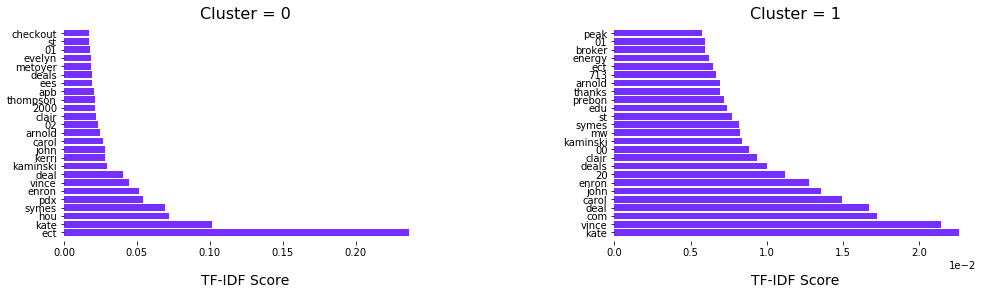

In [21]:
fig = plt.figure(figsize=(15,60), facecolor='w')
x=np.arange(len(dfs2[0]))
for i, df in enumerate(dfs2):
    ax=fig.add_subplot(1,len(dfs2),i+1)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("TF-IDF Score", labelpad=16, fontsize=14)
    ax.set_title("Cluster = "+str(i),fontsize=16)
    ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,2))
    ax.barh(x,dfs2[i].score,align='center',color ='#7530ff')
    ax.set_yticks(x)
    ax.set_ylim([-1,x[-1]+1])
    yticks=ax.set_yticklabels(dfs2[i].features)
    plt.subplots_adjust(bottom=0.9, right=0.97,top=0.95,wspace=0.52)
plt.show()
    
    
    

So we have the words in the emails had the words separated into different clusters.  While it's not perfect (we are missing a bunch og the data so we can manage to run the code), it does separate mostly names and hot-button words with someother more common words.  We'll use these two dataframes in supervised learning.


Since we have a supervised model ready in the hopper, we'll need to split the data into a training and testing set. ScikitLearn has a great tool that makes this easy. We'll set our test size to be 20%.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,labels, test_size=.2, random_state=42)

Now we're ready to use all the work that we put in for the supervised model.  Now that we have labels, our question becomes a classification problem.  We have a number of models to choose from but in this case I chsoe to use a K-Nearest Neighbors (KNN) classifer. 

KNN is a non-parametric method that can be used in regression in addition to classification.  As a classification algorithm, the result is a class 'membership'. The words are classified by a vote of its neighbors, with the word being assigned to the class most common among its _k_ nearest neighbors (k is a positive integer, typically small). Additionally, KNN is a lazy learning algorithm, where the function is only approximated locally and all computation is deferred until classification.  This should give our hardrives a bit of a breather given our data size.


We'll initialize with three neighbors and fit the model on the training set.

In [23]:
#Number of neighbors
n = 3

#creating our knn object
knn = KNeighborsClassifier(n_neighbors=n)

In [24]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Now that the model is fitted we should use it to make predictions.  

![crystalball](images/crystal%20ball.png)

In [25]:
#predicting using test set
pred = knn.predict(X_test)

We loaded a number of the metrics that sklearn has available for looking at the model performance.  We can print all of them out to see how well we did.  

In [26]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(accuracy_score(y_test,pred))

[[11795  1636]
 [ 1286 84394]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     13431
           1       0.98      0.98      0.98     85680

    accuracy                           0.97     99111
   macro avg       0.94      0.93      0.94     99111
weighted avg       0.97      0.97      0.97     99111

0.970517904168054


In [58]:
#creating a dataframe to plot the confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, pred),range(2),range(2))
#creating labels for heatmap
labels = confusion_matrix(y_test, pred)


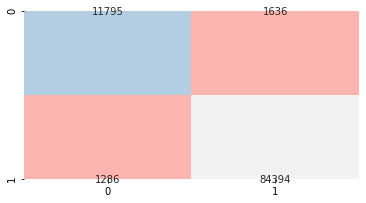

In [74]:

sns.heatmap(df_cm, annot=labels, fmt='.5g',square= True, cmap='Pastel1',cbar=False)
plt.show()

![matrix](images/matrix.png)

That's great accuracy for our model!!  The precision, recall, and F1 scores are all good as well.   

Remember that:
 - __Precision__ = Ratio of Total True Positive vs. Total Predicted Positive - used when when the costs of False Positives are high
 - __Recall__ = Ratio of Total True Positive vs. Total Actual Positive - used when the costs of False Negatives are high
 - __F1-Score__ = Function of Precision and Recall - represents a balance between Precision and Recall and is the preferred metric when there is uneven class distribution


_So what does this all mean?_

## This means...

...we have an efficient model to review email's that have been trained to find people worth investigating.

The Kmeans algorithm separated the email body into people and words.  These people who were say in the top 20, were all implicated in some way during the Enron scandal in 2001.  Then to make our future selves more efficient we took those clusters, called them 'true' labels in the KNN algorithm and used that to look at the words.  With over 90% accuracy we were able to classify these words as important people or not.

## Great, now...

...that we have a trained method, we should be able to take new emails and find people who might be worth a second look.  The application in Fraud and Risk management is really very clear.  A company can use a trained algorithm like this to find the people who may be at risk of committing fraud.  It could be that the person is really in a central position and has access to a large amount of sensitive data, it could also be the person is a 'deal executor' and has significant power over the bottomline.  Whatever the reason, if an algorithm pair like this suggests a person is worth reviewing the next step would be to have a fraud analyst do a more in depth investigation.  The machine learning is great first step and frees up business resources for other activities, but it does not eliminate the need for human intervention.    

![stop](images/stop%20fraud.png)

## If we had more time...

We could further our work in a number of ways.  First, we could find the necessary resources to be able to run the algorithm on the full dataset.  Second, we could break our clustering and classifying into two steps: find the people of interest and then going on to look at the language they used in their emails to see if that could be a red flag for fraud in itself.  Finally, we could try a number of different clusters or neighbors to see if we could further improve model performance.



## Full Process Outline


### Part 1 - Obtaining and Scrubbing
1. Looping over the collection of files for the Enron email data set
2. Created function to parse the emails into lists, then looped it over all the files
3. Saved all the email sections into a dataframe
4. Reviewed summary statistics and dropped nan's
5. Scrubbed date and time stamp from the emails
6. Visualized the email traffic by date using a scatter plot
7. Counted the number of emails per day in a distplot
8. Separated recipients into 3 columns as the top 3 recepients in each email and added them back into the dataframe
9. Created 3 visualizations, an Arc plot, a Circos plot, and a Network map, for looking at the shape and density of a network using the whole dataset
10. Pulled the top 1,000 edges and their nodes to make a new trio of network plots as the full dataset was too dense to review
11. Calculated degree centrality and made a list of top senders and top recipients using centrality as the metric
12. Stored necessary variables and saved dataframe as a .csv for use in other notebooks

### Part 2 - Scrubbing and Exploration
13. Loaded saved files and variables
14. Find the top sender to use as a test case since the dataset is so large
15. Tokenize text and process test case using the frequency distribution in NLTK
16. Repeat with the full dataset
17. Revise text body by removing additional words and characters that were not part of the stop word list 
18. Run tokenization and frequency distributoin again.
19. Review top words using a bar graph
20. Utilizing the WordCloud library to create a word cloud for the top words
21. Revised the wordcloud by making the text all lowercase.
22. Storing variables for use in other notebooks

### Part 3  - Scrubbing and Exploration
23. Loaded saved files and variables
24. Review the dimension of the dataset
25. Using the NLTK methods, implement part of speech tagging and named entity chunking on test case
26. Both tag and chunk the top 2,000 words
27. Implement the tagging on the full email body set, including checkpoints
28. Use a cumulative distribution to review top word frequency


### Part 4 - Modeling and Interpretation
29. Open saved dataframe from the .csv file
30. Vectorize the email bodies using the TFIDF vectorizer from sklearn
31. Use PCA to make the coordinates so we can plot the vectors in matplot
32. Force vectors into a dataframe with their scores
33. Use the dataframe as weightings and features for a new wordcloud image
34. Initializing a 2-cluster K-means object to work on the 10,000 x 10,000 word matrix we created 
35. Plotting the weightings from our algorithm with each cluster a different color
36. Rerunning the previous steps with a larger slice of the data
37. Adding the top features to a new dataframe with the scores produced by the algorithm
38. Remake the dataframe sorted by descending scores
39. Create a list of dataframes by cluster and add the cluster as a new column
40. Plot top text in each cluster
41. Save the dataframes for use in supervised machine learning as well as our variables as .csv files
42. Load dependent and independent variables from .csv files
43. Convert to a list and matrix respectively
44. Split the data into a training and test set
45. Fit the k-nearest neighbors model from sklearn using training set
46. Use the model to predict the cluster on the test set
47. Print the model accuaracy scores and evaluate
48. Business implications and recomendations
49. Possible future analysis
50. Process outline